In [1]:
import tensorflow as tf
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-11 19:07:24.280378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Create random data between (-10, 10) and determine groundtruth
simIn = 20 * torch.rand((1000, 1)) - 10
groundTruth = np.cos(simIn)

In [3]:
# Calculate the number of parameters in a neural network
def calculate_parameters(inputModel):
    v = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return v

In [4]:
# Set up NN for cos(x) training - 2 Hidden Layers, 32 parameters - Shallow Network
class NNOptimize(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, v):
        v = F.relu(self.fc1(v))
        v = F.relu(self.fc2(v))
        v = self.fc3(v)
        return v

In [5]:
# Set up necessary auxilaries for neural net training
optimum_network = NNOptimize()
costFun = nn.MSELoss()
opt = optim.Adam(optimum_network.parameters(), lr=0.01)

In [6]:
def minimumRatio(w):
    c = 0
    t = 0
    for x in w:
        if(x>0):
            c += 1
        t +=1
    return c/t

In [7]:
def calculate_gradient_fun(model):

    g = []
    for p in model.modules():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            g.append(param_norm)

    g_mean = np.mean(g)
    return g_mean

In [8]:
min_ratio = []
l = []
train_count = 100
for i in range(train_count):
    EPOCHS = 45
    lss = 0
    optimum_network = NNOptimize()
    costFun = nn.MSELoss()
    opt = optim.Adam(optimum_network.parameters(), lr=0.01)
    for epochIndex in range(EPOCHS):
        optimum_network.zero_grad()
        output = optimum_network(simIn)
        cost = costFun(output, groundTruth)
        with torch.no_grad():
            lss += (costFun(output, groundTruth))
        cost.backward()
        opt.step()
    l.append(lss/len(simIn))
    num_param = calculate_parameters(optimum_network)
    
    # Allocate Hessian size
    H = torch.zeros((num_param, num_param))

    y_hat = optimum_network(simIn)
    y = simIn
    loss  = ((y_hat - y)**2).mean()

    J = torch.autograd.grad(loss, list(optimum_network.parameters()), create_graph=True)
    J = torch.cat([e.flatten() for e in J]) # flatten

    # Fill in Hessian
    num_param = calculate_parameters(optimum_network)
    for i in range(num_param):
        result = torch.autograd.grad(J[i], list(optimum_network.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result]) # flatten
    w, v = np.linalg.eig(H)
    min_ratio.append(minimumRatio(w))

In [9]:
calculate_gradient_fun(optimum_network)

0.0943079696347316

In [10]:
num_param = calculate_parameters(optimum_network)

In [11]:
H = torch.zeros((num_param, num_param))

y_hat = optimum_network(simIn)
y = simIn
loss  = ((y_hat - y)**2).mean()

J = torch.autograd.grad(loss, list(optimum_network.parameters()), create_graph=True)
J = torch.cat([e.flatten() for e in J])

for i in range(num_param):
    result = torch.autograd.grad(J[i], list(optimum_network.parameters()), retain_graph=True)
    H[i] = torch.cat([r.flatten() for r in result])

Text(0, 0.5, 'l')

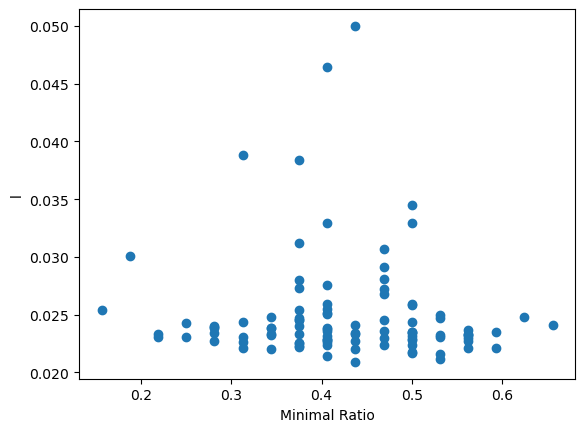

In [12]:
plt.scatter(min_ratio, l)
plt.xlabel('Minimal Ratio')
plt.ylabel('l')